### Import the necessary libraries

In [1]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

Using TensorFlow backend.


In [2]:
pip install unrar

  Stored in directory: /root/.cache/pip/wheels/c7/a9/1a/c5a381df313452ec2a000c9eae2188a2963df5f2f940073a5f
Successfully built unrar


In [0]:
tf.keras.backend.clear_session()

### Load the training data from train.csv file

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
project_path = "/gdrive/My Drive/Colab Notebooks/Sequence Models in NLP/Data/"

In [0]:
train_labels = pd.read_csv(project_path+'/train_labels.csv')

### Print the shape of the train dataset

In [6]:
train_labels.shape

(173, 8)

In [7]:
train_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

project_path = "/gdrive/My Drive/Colab Notebooks/Sequence Models in NLP/Data/"
TRAIN_CSV = project_path+"train_labels.csv"

#VALIDATION_CSV = DATASET_FOLDER+"validation.csv"

#images_zip_path = project_path + "images_racoon.rar"

#from unrar import rarfile

#with rarfile (images_zip_path, 'r') as z:
  #z.extractall()

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
paths = []
coords = np.zeros((sum(1 for row in range(173)), 4))
for col, row in train_labels.iterrows():
    image_height, image_width, x0, y0, x1, y1 = row['height'], row['width'], row['xmin'], row['ymin'], row['xmax'], row['ymax']  
    path = project_path + 'images/'+ row['filename']
    coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
    coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
    coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
    coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
    paths.append(path)

In [10]:
coords

array([[4.69498069e+01, 3.95876289e+01, 3.55830116e+01, 3.82680412e+01],
       [5.81818182e-01, 2.96296296e-01, 8.88242424e+01, 1.27407407e+02],
       [1.57866667e+01, 3.42400000e+01, 4.39466667e+01, 5.85600000e+01],
       [4.84266667e+01, 2.97600000e+01, 3.75466667e+01, 6.56000000e+01],
       [2.71941392e+01, 2.28324324e+01, 6.51721612e+01, 6.50378378e+01],
       [7.49268293e+00, 5.72357724e+00, 1.09892683e+02, 1.19154472e+02],
       [2.53866667e+01, 6.72000000e+00, 5.31200000e+01, 1.20960000e+02],
       [5.24750958e+01, 6.63212435e+00, 6.96398467e+01, 1.03461140e+02],
       [5.14056225e-01, 6.33663366e-01, 7.86506024e+01, 1.10891089e+02],
       [4.29961390e+01, 5.27835052e+00, 4.69498069e+01, 5.34432990e+01],
       [1.30957096e+01, 4.62650602e+00, 7.01254125e+01, 1.21060241e+02],
       [8.40154440e+00, 2.57319588e+01, 1.09714286e+02, 7.12577320e+01],
       [4.35200000e+00, 3.12320000e+01, 6.70720000e+01, 9.65120000e+01],
       [6.83333333e+00, 6.66666667e-01, 1.07000000e

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [11]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
print("First few paths",paths[0],paths[1])
for i, f in enumerate(paths):
    try :
      img = Image.open(f) # Read image
      img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
      img = img.convert('RGB')
      batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
    except :
      pass

First few paths /gdrive/My Drive/Colab Notebooks/Sequence Models in NLP/Data/images/raccoon-17.jpg /gdrive/My Drive/Colab Notebooks/Sequence Models in NLP/Data/images/raccoon-11.jpg


### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [12]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

W0616 11:53:13.772326 140617896183680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 11:53:13.783845 140617896183680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 11:53:13.793628 140617896183680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 11:53:13.817050 140617896183680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0616 11:53:13.818115 1406178961

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [14]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)

W0616 11:53:26.659989 140617896183680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0616 11:53:26.698811 140617896183680 deprecation.py:323] From <ipython-input-13-580612f9cb82>:26: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable,

Epoch 1/30
173/173 [==============================] - 3s 17ms/step - loss: 2839.6213 - IoU: 0.0868
Epoch 2/30
173/173 [==============================] - 0s 618us/step - loss: 647.8688 - IoU: 0.4301
Epoch 3/30
173/173 [==============================] - 0s 573us/step - loss: 644.3102 - IoU: 0.5361
Epoch 4/30
173/173 [==============================] - 0s 574us/step - loss: 583.5215 - IoU: 0.5395
Epoch 5/30
173/173 [==============================] - 0s 581us/step - loss: 336.7286 - IoU: 0.5841
Epoch 6/30
173/173 [==============================] - 0s 581us/step - loss: 280.0563 - IoU: 0.5820
Epoch 7/30
173/173 [==============================] - 0s 528us/step - loss: 254.2945 - IoU: 0.5907
Epoch 8/30
173/173 [==============================] - 0s 536us/step - loss: 198.6605 - IoU: 0.6635
Epoch 9/30
173/173 [==============================] - 0s 515us/step - loss: 166.7915 - IoU: 0.6965
Epoch 10/30
173/173 [==============================] - 0s 547us/step - loss: 142.9014 - IoU: 0.7153
Epoch 11/

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = project_path + 'images/'+train_labels['filename'][10]
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [28]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox
print(region)

[ 20.813995   7.111927  91.62985  141.56837 ]


### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

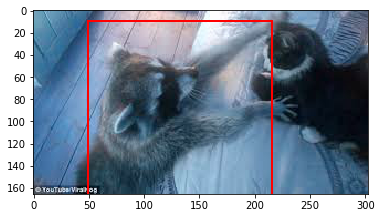

In [29]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## Time Series Analysis using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temperature values to "Temperature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temperature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

### Import required libraries

#### Mount google drive

### Load the  data file

In [26]:
df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Sequence Models in NLP/Data/daily-minimum-temperatures-in-me.csv', index_col='Date')
df.sort_index(inplace=True)
df.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


### Plot the data

In [27]:
df.shape

(3650, 1)

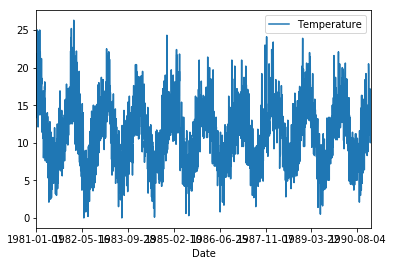

In [28]:
df.plot()

### Check for null values and treat them

In [29]:
#Check for null values
df.isnull().sum()

Temperature    0
dtype: int64

#### Drop null values (if any)

In [0]:
#Drop NA
df.dropna(inplace=True)

### Get the representation of the distribution of data in the form of histogram

(array([ 53., 181., 564., 862., 830., 670., 347., 102.,  32.,   9.]),
 array([ 0.  ,  2.63,  5.26,  7.89, 10.52, 13.15, 15.78, 18.41, 21.04,
        23.67, 26.3 ]),
 <a list of 10 Patch objects>)

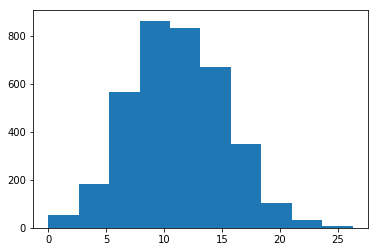

In [32]:
plt.hist(df['Temperature'])

### Check the maximum and minimum values

In [33]:
#Check Data Range
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
#Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

### Check the maximum and minimum values of scaled data

In [36]:
#Check Data Range
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


### Split data into Training and Testing set 
<u>Note</u> The train and test data has to be sequential. Keep the first 70% of data in training and the bottom 30% in test data 

In [37]:
#70% examples will used for training (in the begining)
train_size = int(len(scaled) * 0.70)

#30% will be used for Test
test_size = len(scaled - train_size)

#Split the data
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


In [38]:
train.shape

(2555, 1)

## Create the sequential data
Map the temperature at a particular time t to the temperature at time t+n, where n is any number you define.

For example: to map temperatures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
#window - how long the sequence will be
def create_dataset(dataset, window=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):
        
        a = dataset[i:(i+window), 0]        
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    
    return np.array(dataX), np.array(dataY)

### Use function to get training and test set

In [0]:
#Create Input and Output
window_size = 2
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [41]:
#Make it 3 Dimensional Data - needed for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 2, 1)
(1093, 2, 1)


### Define sequntial model, add LSTM layer and compile the model

In [0]:
import tensorflow as tf

In [43]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=(window_size, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

W0616 11:08:53.730403 140211384620928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Train the model for 100 epochs with batch size = 1

In [44]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=1)

W0616 11:09:40.449265 140211384620928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2553 samples, validate on 1093 samples
Epoch 1/100
2553/2553 [==============================] - 20s 8ms/sample - loss: 0.0143 - val_loss: 0.0096
Epoch 2/100
2553/2553 [==============================] - 18s 7ms/sample - loss: 0.0108 - val_loss: 0.0097
Epoch 3/100
2553/2553 [==============================] - 18s 7ms/sample - loss: 0.0104 - val_loss: 0.0086
Epoch 4/100
2553/2553 [==============================] - 18s 7ms/sample - loss: 0.0105 - val_loss: 0.0086
Epoch 5/100
2553/2553 [==============================] - 19s 7ms/sample - loss: 0.0103 - val_loss: 0.0086
Epoch 6/100
2553/2553 [==============================] - 18s 7ms/sample - loss: 0.0102 - val_loss: 0.0087
Epoch 7/100
2553/2553 [==============================] - 18s 7ms/sample - loss: 0.0103 - val_loss: 0.0096
Epoch 8/100
2553/2553 [==============================] - 18s 7ms/sample - loss: 0.0103 - val_loss: 0.0086
Epoch 9/100
2553/2553 [==============================] - 18s 7ms/sample - loss: 0.0103 - val_loss: 0.008

### Make Predictions and Evaluate your model

In [47]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=1)

model.reset_states()

testPredict = model.predict(X_test, batch_size=1)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.48 RMSE
